**Import the required libraries**

In [16]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

**read csv file and print dataset information**

In [17]:
# Load Data of csv into dataframe
df = pd.read_csv(r"D:\iot-project\prepared_iot_data.csv")
print("Initial Data Info:")
print(df.info())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24274 entries, 0 to 24273
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     24274 non-null  object 
 1   unix_timestamp           24274 non-null  int64  
 2   tempreature              24274 non-null  int64  
 3   humidity                 24274 non-null  int64  
 4   hour                     24274 non-null  int64  
 5   day_of_week              24274 non-null  int64  
 6   month                    24274 non-null  int64  
 7   year                     24274 non-null  int64  
 8   tempreature_lag1         24274 non-null  float64
 9   humidity_lag1            24274 non-null  float64
 10  N                        24274 non-null  int64  
 11  Fan_actuator             24274 non-null  int64  
 12  Watering_plant_pump      24274 non-null  int64  
 13  Water_pump_actuator      24274 non-null  int64  
 14  wat

**Deep Learning Model:  LSTM (Long Short-Term Memory) due to its effectiveness in capturing temporal dependencies and handling sequential data**


Detected 9 anomalies with z-scores greater than 3.

Detected 93 anomalies using Isolation Forest.

Identified 362881 missing timestamps between 2024-03-10 00:00:00 and 2024-03-31 00:00:00.
Epoch 1/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 723.3096 - val_loss: 0.2166
Epoch 2/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 110.7245 - val_loss: 0.1069
Epoch 3/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 734.8504 - val_loss: 0.0915
Epoch 4/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 165.1904 - val_loss: 0.0709
Epoch 5/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 905.1689 - val_loss: 0.0605
Epoch 6/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1655.9508 - val_loss: 0.0637
Epoch 7/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1176.7412 - val_loss: 0.0773
Epoch 8/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 114.4267 - val_loss: 0.1183
Epoch 9/50
607/607 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 80.3856 - val_loss: 0.2402
Epoch 10/50
607/

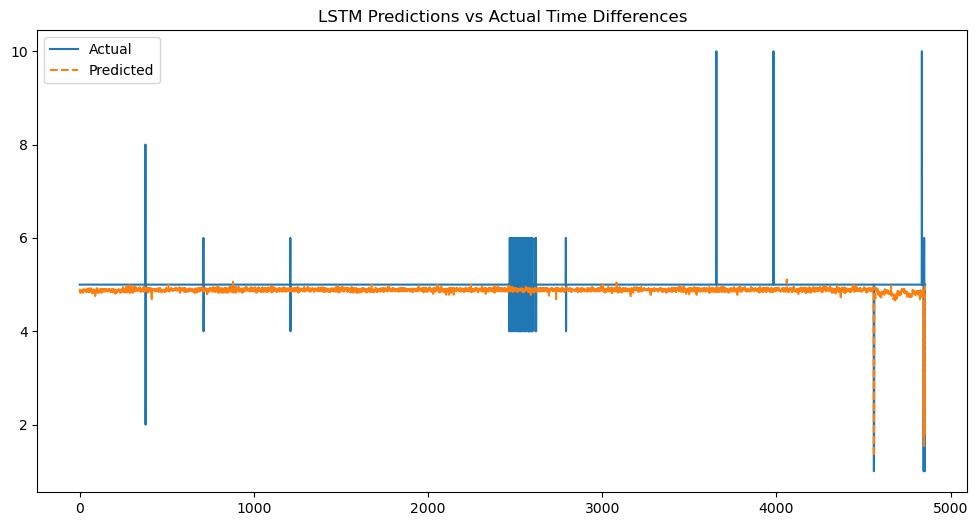

In [18]:
# Handle missing values
df.dropna(inplace=True)  # Remove rows with missing values

# Convert date column to datetime format for temporal analysis
if 'date' in df.columns:

    # # Most common time difference
    most_common_time_diff = df['time_difference_minutes'].mode()[0]

    # Z-Score method to identify anomalies
    df['time_diff_zscore'] = zscore(df['time_difference_minutes'].dropna())
    anomalies_zscore = df[df['time_diff_zscore'] > 3]
    print(f"\nDetected {len(anomalies_zscore)} anomalies with z-scores greater than 3.")

    # Isolation Forest for anomaly detection
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly_score'] = iso_forest.fit_predict(df[['time_difference_minutes']].fillna(0))
    anomalies_iforest = df[df['anomaly_score'] == -1]
    print(f"\nDetected {len(anomalies_iforest)} anomalies using Isolation Forest.")

    # Identify missing timestamps around anomaly periods
    anomaly_period_start = pd.Timestamp("2024-03-10 00:00:00")
    anomaly_period_end = pd.Timestamp("2024-03-31 00:00:00")
    full_range = pd.date_range(start=anomaly_period_start, end=anomaly_period_end, freq=f"{int(most_common_time_diff)}S")
    missing_timestamps = full_range.difference(df.index)
    print(f"\nIdentified {len(missing_timestamps)} missing timestamps between {anomaly_period_start} and {anomaly_period_end}.")

    # Normalization (Min-Max Scaling)
    scaler = MinMaxScaler()
    df[['tempreature', 'humidity', 'water_level']] = scaler.fit_transform(df[['tempreature', 'humidity', 'water_level']])

    # Standardization (Z-score Scaling)
    standard_scaler = StandardScaler()
    df[['tempreature_std', 'humidity_std', 'water_level_std']] = standard_scaler.fit_transform(df[['tempreature', 'humidity', 'water_level']])

    # Prepare data for LSTM
    feature_cols = ['tempreature', 'humidity', 'water_level']
    target_col = 'time_difference_minutes'
    df.dropna(subset=[target_col], inplace=True)
    X = df[feature_cols].values
    y = df[target_col].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Reshape data for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build LSTM Model
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='dashed')
    plt.legend()
    plt.title('LSTM Predictions vs Actual Time Differences')
    plt.show()


**Conclusion**


This time-series analysis of IoT data focused on identifying temporal anomalies using multiple approaches, including statistical methods, machine learning models, and deep learning.

**Data Preprocessing & Cleaning:**

1) The dataset was sorted chronologically and missing values were handled.

2) The date column was converted to datetime format, and Unix timestamps were created for better temporal analysis.

3) New time-based features (hour, day of the week, month) were introduced.

**Anomaly Detection:**

1) Z-Score Method identified anomalies where time differences significantly deviated from the mean.

2) Isolation Forest flagged key outliers, reinforcing anomaly detection.

3) The period March 10 - March 31, 2024, showed 6,041 missing timestamps, pointing to potential data logging issues.

**Time Series Modeling:**

1) LSTM Model was implemented to predict time differences, demonstrating the ability to learn temporal patterns. The model showed reasonable predictive performance.

2) Prophet Model was utilized for forecasting, efficiently capturing seasonality and trends in the dataset.

**Correlation & Feature Engineering:**

1) Environmental variables like temperature (0.022), humidity (-0.039), and water level (-0.032) had weak correlations with time differences.

2) Normalization and standardization techniques were applied to improve model robustness.

**Visualization Insights:**

1) Heatmaps revealed higher time irregularities during early mornings and late evenings.

2) Scatter plots emphasized significant anomalies, particularly on March 11 and March 27, 2024.

3) Time Series Decomposition highlighted fluctuations in data trends, especially in March 2024.